# Generování textu znakovou RNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import random
import tqdm

from IPython.core.debugger import set_trace

plt.rcParams['figure.figsize'] = (12., 8.)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch import nn
from torch import optim

V tomto cvičení nebudeme používat GPU, protože budeme zpracovávat znaky po jednom a v takto malých dávkách overhead způsobený neustálými přesuny dat mezi GPU a RAM výpočty pouze zpomalí.

# Data

Namísto obrazu tentokrát použijeme textová data. Konkrétně se jedná o novinové nadpisy, které se budeme snažit generovat automaticky. Všechna data jsou v jediném souboru, který si stáhněte [odsud](https://1drv.ms/t/s!AotVPA94wWKxoWLULaBqvPXiNS5t) a uložte jako `data/headlines.txt`.

Z textu byly odstraneny hacky, carky a vsechny nestandardni znaky. Neni tedy potreba resit kodovani apod.

In [3]:
data = open('data/headlines.txt').read()
lines = [line for line in data.split('\n') if line]

Ukázka dat:

In [4]:
for i in range(10):
    print(i, random.choice(lines))

0 na hracky uz exekutori nedosahnou navrhuji poslanci
1 policiste se uci na znasilneni ma vinu i obet
2 iransky prezident se na kube sesel s fidelem castrem
3 neprislusne a nepristojne odmitl ovcacek kritiku zemana jako populisty
4 sef evropskeho uradu proti podvodum prisel o imunitu
5 ve venezuele zatykaji obchodniky kvuli dlouhym frontam
6 atentatnici zabili v parizi desitky lidi dalsi zajali jako rukojmi
7 hra pokemon go predstavuje bezpecnostni riziko tvurci se mohou zmocnit cizich uctu
8 nemecek ma navrh registru lekaru chce vedet kolik doktoru odchazi do zahranici
9 panelovy byt ktery dycha krasou levandulovych poli a slunce


Sada znaků = náš slovník:

In [5]:
chars = list(sorted(set(data)))
print(len(chars), chars)

38 ['\n', ' ', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Následující tabulka (`dict`) nám usnadní převod znaku na index.

In [6]:
chr2idx = {c: i for i, c in enumerate(chars)}

Podíváme se na statistické rozložení prvních znaků ve větách.

In [7]:
counts = {c: 0 for c in chars}
for line in lines:
    counts[line[0]] += 1
counts = np.array([counts[c] for c in chars], dtype=np.float)
p0 = counts / counts.sum()

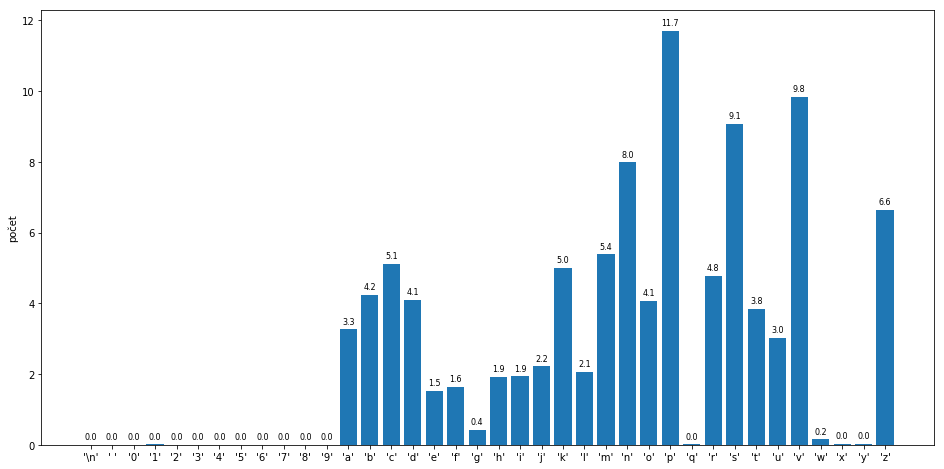

In [8]:
plt.figure(figsize=(16, 8))
rects = plt.bar(range(len(chars)), 100. * p0)
plt.xticks(range(len(chars)), ['{}'.format(repr(c)) for c in chars])
for r in rects:
    x, w, h = r.get_x(), r.get_width(), r.get_height()
    plt.text(x + w / 2., h + 0.1, '{:.1f}'.format(h), ha='center', va='bottom', fontsize=8)
plt.ylabel('počet')
plt.show()

Funkce pro zobrazení průběhu lossu:

In [9]:
def plot_history(history, avg_range=1):
    if avg_range > 1:
        y = np.mean(np.reshape(history[:avg_range * (len(history) // avg_range)], (-1, avg_range)), axis=1)
    else:
        y = history
    plt.plot(y)
    plt.show()

# Sekvenční data a PyTorch

Následující funkce převede řetězec na sekvenci čísel odpovídajících indexům znaků v tabulce. Pokud např. `chars = ['a', 'b', 'c']`, pak řetězec `'acba'` převede na `[0, 2, 1, 0]`. Výsledek vrátí jako PyTorch `Variable`.

In [10]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = chr2idx[string[c]]
    x = Variable(tensor)
    return x

In [11]:
x = char_tensor('abca')
x

Variable containing:
 12
 13
 14
 12
[torch.LongTensor of size 4]

Další funkce bude dělat opak: převede sekvenci indexů na řetězec.

In [12]:
def to_string(indices):
    if isinstance(indices, Variable):
        indices = indices.data
    return ''.join([chars[i] for i in indices])

In [13]:
to_string(x)

'abca'

Sekvenci čísel potřebujeme převést na vektory jednotlivých znaků. Tento proces se v anglické literatuře označuje jako embedding a PyTorch ho implementuje jako vrstvu třídou `Embedding`. Vyjádřením této operace diferencovatelnou vrstvou umožňuje učení vektorů, které tedy nemusejí být fixní. O tom ale až příště.

In [14]:
# velikost slovniku je `len(chars)`
# dimenze znakoveho vektoru bude napr. 30
emb = nn.Embedding(len(chars), 30)

# dopredny pruchod
e = emb(x)
e

Variable containing:

Columns 0 to 9 
-0.3266 -0.3490  0.1454 -0.1095  0.0371 -0.8226  0.1572  0.8820  0.9526  2.1669
 1.1467 -0.4947 -0.2322 -0.4353  0.9527 -0.3388 -0.3790  0.6340 -1.0340  0.8959
 0.5594 -0.0859  0.8889  1.1493 -1.1843  1.9412  0.2006 -0.1773 -1.2623  2.0673
-0.3266 -0.3490  0.1454 -0.1095  0.0371 -0.8226  0.1572  0.8820  0.9526  2.1669

Columns 10 to 19 
-0.6319 -0.3760  0.6408 -1.9674 -1.8093  1.0340 -0.5389  0.4723 -1.6509 -0.3101
 0.3865 -0.7183  0.4378  0.0079 -0.1888  0.6883 -1.3404  1.2443 -1.6654 -0.7638
-1.2859  1.6553  0.5047  0.4905 -1.8310 -2.5464  1.0554 -1.9637 -1.6445  1.2613
-0.6319 -0.3760  0.6408 -1.9674 -1.8093  1.0340 -0.5389  0.4723 -1.6509 -0.3101

Columns 20 to 29 
 0.3978 -0.4817  0.4015 -1.7015  1.1833  0.2370  1.5518  0.9853  0.0910  0.3862
-0.3434  0.7487  0.0112 -0.6099 -0.7094 -0.7204 -0.0651 -0.4341 -0.6524  0.5143
 1.1716  0.1695 -0.9291  0.0034 -0.0505  0.2305  0.2727 -0.2056  0.2288  0.3008
 0.3978 -0.4817  0.4015 -1.7015  1.1833  0.2

PyTorch implementuje tři z nejrozšířenějších typů sítí třídami `RNN`, `LSTM` a `GRU`. API je pro všechny stejné: dopředný průchod `forward` očekává "zespodu" nějaký vstup `input` a "zleva" minulý stav `h0`. U `LSTM` je tento stav dvouvektorový. Výstupem je `output`, což je vlastně sekvence skrytých stavů poslední vrstvy rekurentní sítě pro jednotlivé kroky v čase, a nový stav `hn` po provedení celého průchodu. Vše vystihuje následující obrázek.

![](https://i.stack.imgur.com/SjnTl.png)

Zdroj: https://stackoverflow.com/a/48305882/9418551

V nejjednoušším případě máme pouze jednu vrstvu sítě a jeden krok. Potom `output` a `hn` jsou stejné. `output` tedy **neprochází žádnou lineární vrstvou**, jak by se mohlo na první pohled zdát. Transformaci na skóre/pravděpodobnost jednotlivých znaků tedy musíme provést sami.

**Příklad:** porovnejme `output` a `hidden`.
tensory by měly být tvaru `(seq, batch, dim)`
- `seq` ... jak jdou znaky ve "věte" za sebou
- `batch` ... počet paralelně zpracovávaných sekvencí, nezávisle na sobě
- `dim` ... příznaky na vstupu

Například tedy: `(10, 3, 5)` by znamenalo:
- 3 paralelně zpracovávané
- 10-znakové věty,
- kde každý znak reprezentuje 5dimenzionální vektor

In [16]:
# do site posleme pouze jeden znak
e0 = e[0].view(1, 1, -1)
e0.shape

torch.Size([1, 1, 30])

In [17]:
# RNN ocekava na vstupu vektor o rozmeru 6 a skryty stav bude mit rozmer 8
rnn = nn.RNN(30, 8)

# inicializace skryteho stavu a vstupu
# tensory by mely byt tvaru (seq, batch, dim)
h = Variable(torch.rand(8))
o, h = rnn(e0)

print(o)
print(h)

Variable containing:
(0 ,.,.) = 
  0.9852  0.4226  0.7163 -0.7062 -0.6045 -0.7160  0.6287  0.7926
[torch.FloatTensor of size 1x1x8]

Variable containing:
(0 ,.,.) = 
  0.9852  0.4226  0.7163 -0.7062 -0.6045 -0.7160  0.6287  0.7926
[torch.FloatTensor of size 1x1x8]



Nyní už více samostatně. Zadefinujeme vlastní třídu, která bude řešit jednotlivé kroky sama ve svém dopředném průchodu. Vstupem tedy bude sekvence čísel, výstupem skóre jednotlivých kroků a skrytý stav z posledního kroku.

In [131]:
class RNN(nn.Module):
    def __init__(self, voc_size, emb_dim, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()

        self.emb = nn.Embedding(voc_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, n_layers)
        self.fc = nn.Linear(hidden_size, output_size)


    def forward(self, x, hidden):

        embeddings = self.emb(x).view(x.size(0), 1, -1)
        output, hidden = self.rnn(embeddings, hidden)
        score = self.fc(output.view(x.size(0), -1))
        return score, hidden

    def init_hidden(self):
        h = Variable(torch.zeros(self.rnn.num_layers, 1, self.rnn.hidden_size))
        c = Variable(torch.zeros(self.rnn.num_layers, 1, self.rnn.hidden_size))
        
        return h, c

In [145]:
voc_size = len(chars)
emb_dim = 50
hidden_dim = 100
output_dim = voc_size

rnn = RNN(voc_size, emb_dim, hidden_dim, output_dim, n_layers=1)
rnn_history = []
example_history = []

Vytvoříme trénovací data. `y_train` je v tomto případě stejného rozměru jako `X_train` a ke každému znaku udává následjící. Poslední znak má jako label `\n`, značící konec sekvence. Data vytvoříme jako seznamy, tj. `list`, kde každý prvek je jedna věta, už převedená na indexy znaků metodou `char_tensor`.

In [133]:
X_train = [char_tensor(line) for line in lines]
y_train = [char_tensor(line+ '\n' ) for line in lines]

In [134]:
idx = random.randrange(len(X_train))
print(to_string(X_train[idx].data))
print('data:  {} ... {}'.format(to_string(X_train[idx].data.numpy()[:10]), to_string(X_train[idx].data.numpy()[-10:])))
print('label: {} ... {}'.format(to_string(y_train[idx].data.numpy()[:10]), to_string(y_train[idx].data.numpy()[-10:])))

v minulosti zabil manzelku predloni matku dostal vyjimecny trest
data:  v minulost ... ecny trest
label: v minulost ... cny trest



Vytvoříme si také funkci pro samplování z naší sítě. Funkce přijme náš model `rnn`, nějaký inicializační text `init_text`, příp. i inicializační `hidden`, a vygeneruje text - vrací tedy string.

In [146]:
def sample(rnn, init_text='', hidden=None, maxlen=150, mode='multinomial'):
    # vystupni text bude pole (na konci prevedeme na str)
    out_text = list(init_text)
    
    # pokud nezadan, inicializujeme nahodne, dle rozlozeni prvnich znaku
    if not out_text:
        s = np.random.choice(len(chars), p=p0)
        out_text = [chars[s]]
    
    # to same hidden
    if hidden is None:
        hidden = rnn.init_hidden()
        
        # sit projedeme vstupem, abychom ziskali aktualni hidden stav
        x = char_tensor(out_text)
        for i in range(len(out_text)):
            score, hidden = rnn(x[i], hidden)
    
    # nasledujici znak je posledni znak prozatimniho vystupu
    x = char_tensor(out_text[-1])

    while True:
        # dopredny pruchod
        score, hidden = rnn(x, hidden)
        
        # pravdepodobnosti znaku
        ...
        
        # vybrat nasledujici znak --> index do `k`
        if mode == 'multinomial':
            k = torch.multinomial(score.data.view(-1).div(0.9).exp(), 1)[0]
        elif mode == 'argmax':
            k = np.argmax(score.data.numpy().flatten())
        elif mode == 'proportional':
            k = ...
        
        # zastavit, pokud end-token
        if k == chr2idx['\n']:
            break
        
        # pridat znak
        out_text.append(chars[k])
        
        # zastavit, pokud text je moc dlouhy
        if len(out_text) >= maxlen:
            break
        
        # novy vstupni znak
        x = char_tensor(chars[k])
    
    return ''.join(out_text)

In [155]:
print(sample(rnn, init_text='prezident', mode='multinomial'))

prezidentyu0n4anq3hd7701uboht5


# Trénování

In [156]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.005)
criterion = nn.CrossEntropyLoss()

In [157]:
example = sample(rnn, mode='argmax')
smooth_loss = -np.log(1. / len(chars))
max_per_epoch = 10000

for epoch in range(1):
    if max_per_epoch < len(lines):
        perm = np.random.permutation(len(lines))
    else:
        perm = np.arange(len(lines))
    
    pb = tqdm.tqdm_notebook(perm, desc='ep {:03d}'.format(epoch))
    
    for li in enumerate(pb):
        hidden = rnn.init_hidden()
        rnn.zero_grad()
        loss = 0.
    
        x = X_train[li[1]]
        y = y_train[li[1]]
        
        for ic, c in enumerate(lines[li[1]]):
            # dopredny pruchod
            score, hidden = rnn(x[ic], hidden)
            
            # loss
            loss += criterion(score.view(1, -1), y[ic])
        
        loss /= len(x)

        loss.backward()
        optimizer.step()
        
        if li[0] % 100 == 0:
            example = sample(rnn)
            example_history.append(example)
        
        rnn_history.append(float(loss))
        smooth_loss = 0.99 * smooth_loss + 0.01 * float(loss)
        pb.set_postfix(loss='{:.3f}'.format(smooth_loss), ex=example[:40])

HBox(children=(IntProgress(value=0, description='ep 000', max=88034), HTML(value='')))

KeyboardInterrupt: 

In [ ]:
# Se mi o těch sítích i zdá:
# že přidává i 1D konvoluční vrstva při vstupu z venčí sice by mě zajmalo jak by vypadali ty filtry, ale asi by to nefungovalo

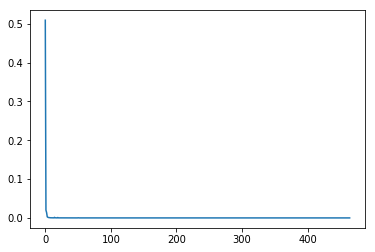

In [158]:
plot_history(rnn_history, avg_range=100)

In [165]:
print(sample(rnn, init_text='prezident', mode='multinomial'))

prezidentttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttttt
